# Polyply Tutorial - Early Life
In this tutorial you will learn how to generate parameter files (i.e. itp-files) and coordinates for simulating synthetic polymers and biomacromolecules with Martini3 using polyply. We will discuss how to generate itp files for simple linear and branched polymers as well as how to include polydispersity. Furthermore this tutorial will show how to generate coordinates and apply a bias to generate phase separated initial systems. 

Polyply is a software suite/library that consists of three separate programs 'polyply gen_params' for parameter file generation, 'polyply gen_coords' for coordinate file generation as well as 'polyply gen_seq', which is an auxiliary program for generation sequences that can be read by the parameter generation program. In this tutorial we are only going to use the two main programs.  

Note that this requires some basic knowledge of python. More simple tutorials can be on found on our GitHub page including a quick-start tutorial. 

*Author: Fabian Grunewald   
Email: f.grunewald@rug.nl

## References
For more details about polyply you can check out the following links:
* For installation instructions, and further tutorials checkout the GitHub [wiki](https://github.com/marrink-lab/polyply_1.0/wiki)
* FAQs are answered [here](https://github.com/marrink-lab/polyply_1.0/wiki/FAQs) 
* For details on the algorithm and implementation checkout the pre-print (https://arxiv.org/abs/2105.05890) 


## Prerequisites
This tutorial assumes you have basic knowledge of and are using:
* a Linux shell 
* GROMACS 2016 (or later)
* Python

and have the following software or libraries installed and available in your PATH
* GROMACS
* polyply version 1.0.1 (or later)
* Python modules: matplotlib, MDAnalysis

### Install Polyply
If you have not installed polyply please close the notebook and install polyply following the [instructions here](https://github.com/marrink-lab/polyply_1.0/wiki/Installation). Then reopen the notebook.

### Run tutorial from within virtual environment 
Note if you intend on running from within a virtual environment you first have to add the ipython kernel to the environment and load it. This is done in two simple steps. First run:
```
pip install ipykernel
```
to install the ipython kernel. Then run the following command to add it to your notebook defaults:
```
python -m ipykernel install --user --name=<name_of_the_environment>
```
After reopening the notebook you'll have to go to kernel and select the virtual environment from the list. 

# Checking polyply installation
Execute the next cell to see if polyply is installed correctly. If it prints "INFO - Couldn't import numba [...]" it means you did not install the numba library. Numba accelerates the polypy structure generation. Thus to increase the speed it is recommended to install it. However, you can run the tutorial without numba and run it again later with numba to see the difference.

In [1]:
try:
    import polyply
except ModuleNotFoundError:
    print("Error: Polyply has not been installed correctly.\nPlease contact the tutorial assistants for more information.")

# Helpful functions

Below are some functions that we need for making nice plots of graphs and computing some volumes later on. Feel free to browse the code but it is not essentially to the tutorial or setting up the system. 

In [2]:
import networkx as nx
import vermouth
import polyply
import numpy as np
import matplotlib.pyplot as plt
import itertools

def longest_simple_paths(graph):
    """
    Find a longest simple path in a graph.
    """
    # 1 find all nodes with degree 1 i.e. end nodes
    end_nodes = [node for node in graph.nodes if nx.degree(graph, node) == 1]
    
    # 2 make all combinates of those nodes to second degree and find length
    #   of all simple paths and compare
    longest_paths = []
    longest_path_length = 0
    for start, stop in itertools.combinations(end_nodes, r=2):
        for path in nx.all_simple_paths(graph, source=start, target=stop):
            if len(path) > longest_path_length:
                longest_path_length = len(path)
                longest_paths = path
    return longest_paths

def semicircle_funcion(npoints, radius, sign=1):
    spacing = [j * (sign*np.pi/npoints) for j in range(npoints)]
    spacing.reverse()
    xcoords = radius * np.cos(spacing)
    ycoords = radius * np.sin(spacing)
    return np.array(xcoords), np.array(ycoords)

def folded_coords(npoints):
    xup, yup = semicircle_funcion(10, 5)
    xdown, ydown = semicircle_funcion(10, 5, -1)
    x = np.hstack((xup, xdown + 10))
    y = np.hstack((yup, ydown))
    
    x_coords = np.empty(0)
    y_coords = np.empty(0)
    
    i=0
    for i in range(0, npoints//20, 1):
        x_coords = np.hstack((x_coords, x + i*20))
        y_coords = np.hstack((y_coords, y))
    
    rest = npoints - len(x_coords)
    x_coords = np.hstack((x_coords, x[range(0, rest)] + (i+1)*20 ))
    y_coords = np.hstack((y_coords, y[range(0, rest)]))
    
    return x_coords, y_coords

def plot_graph_nicley(graph, link_labels=False, colors=None, shape_dict=None):
    """
    Make a plot of a graph, but in a way that is optimized to present largely linear,
    graphs that have few branches. 
    """
    longest_path = longest_simple_paths(graph)
    x_coords, y_coords = folded_coords(len(longest_path))
    opt_dist = ((x_coords[0]-x_coords[0])**2. + (y_coords[0]-y_coords[1])**2.)**(1/2.)
    pos = { node: np.array([x, y]) for node, x, y in zip(longest_path, x_coords, y_coords)}
    pos.update({node: np.random.random(2) for node in graph.nodes if node not in longest_path })
    pos = nx.fruchterman_reingold_layout(graph, pos=pos, fixed=longest_path, k=opt_dist)
    node_list = list(graph.nodes())
    if colors:
        node_color = [colors[graph.nodes[node]["resname"]] for node in graph.nodes] 
    else:
        node_color = None
        
    nx.draw(graph, 
            nodelist=node_list,
            pos=pos, 
            node_size=400, 
            with_labels=True,
            node_color=node_color)
     
def volume_sphere(r):
    """
    Compute volume of sphere from radius r.
    """
    return r**3. * 4/3 * np.pi

def volume_sphereical_cap(r, h):
    """
    Compute volume of spherical cap from radius r and height h. 
    """
    return (1/3)*np.pi*h**2.*(3*r - h)

def molecular_weight_distr(weights):
    """
    Given an array of molecular `weights` generate a distrbution and
    normalize it. 
    
    Parameters
    ----------
    weights `abc.iteratable`
        array or list of molecular weights
    
    Returns
    -------
    `abc.iteratable`
        probabilities to encounter a particular molecular weight
    `abc.itertable`
        matching molecular weights
    """
    hist, bin_edges = np.histogram(weights, density=False, bins=50)
    average_weights = 162*((bin_edges[:-1]-bin_edges[1:]/2.) + bin_edges[:-1])
    return hist/np.sum(hist), average_weights

def number_average_molecular_weight(probs, weights):
    """
    Compute the number average molecular weight from the probability
    distribution function given bei probabilites and corresponding weights.
    """
    return np.sum(probs * weights)

def weight_average_molecular_weight(probs, weights):
    """
    Compute the weight average molecular weight from the probability
    distribution function given bei probabilites and corresponding weights.
    """
    return np.sum(np.square(weights)*probs)/number_average_molecular_weight(probs, weights)

def polydispersity_index(occurance, weights):
    """
    Compute the polydispersity index molecular weight from the probability
    distribution function given bei probabilites and corresponding weights.
    """
    return weight_average_molecular_weight(occurance, weights) / number_average_molecular_weight(occurance, weights)

## The case study: Aqueaous two phase systems of Dextran and PEG

In this tutorial we want to generate input files and parameters for simulating a two phase aqueous system of PEG and Dextran inside a lipid bilayer vesicle. 

Liquid-liquid phase separation (LLPS) is an important driving force in both biotechnological applications and biological systems. Systems capable of undergoing LLPS are therefore of high 
interest to many researchers and are not only studied experimentally but also at various levels of  theory.[1][2]  Concerning  cellular  processes,  LLPS  is  speculated  to  have  promoted  the  early stages of life by allowing to form simple compartmentalization, which eventually lead to the evolution of membrane-less organelles inside modern day cells.[3][4] As such, studying LLPS in the context of cellular environments is of considerable interest.

This system presents three main challenges: 1) PEGylated lipids require the addition of PEG to the lipids of the vesicle and need to be placed without penetrating the bilayer; 2)  Dextran  is  a  branched  sugar  polymer,  which  typically  has  a  statistical  distribution  of molecular weights and branches; 3) the ATPS needs to be generated in the phase separated state as to same excessive equilibriation time. To tackle these challenges the tutorial is also split in three parts. First we generate itp-files for the PEGylated lipids, then for Dextran using a simple statistical distribution. Finally we generate coordinates for the combined system. 

*Last two paragraphs are a excerpt from: "Polyply: a python suite for facilitating simulations of (bio-) macromolecules and nanomaterials" (2021) published on arXiv*

## 1 - Input files for PEG(50) and PEGylated lipids
At the heart of the polyply input file generation lies a graph transformation. The user provides a residue graph, which is then converted to a graph a target resolution (i.e. CG Martini level). In the course of this transformation atom/bead parameters and bonded parameters of the building blocks are combined to obtain the final itp-file. Parameters of the building blocks are either part of the polyply library or can be provided by the user. For more information see ref [5].

To generate the itp files for the PEGylated lipids and the PEG, we have to know their molecular weight. According to our target system the PEG part of the PEGylated lipid should be 2000 g/mol (i.e. ~45 residues) and the PEG inside the vesicle has a molecular weight of 8000 g/mol (i.e. 180 residues). 

For making parameters of the PEGylated lipid we need building block parameters for the lipid part - in this case POPC - and for PEG part. To check if those are available in the library run the following command. It will list all the building blocks for the martini3 force-field library that are known to polyply.

In [3]:
!polyply -list-blocks martini3

The following Blocks are present in the following libraries: ['martini3']:
GLY
ALA
CYS
VAL
LEU
ILE
MET
PRO
HYP
ASN
GLN
ASP
GLU
THR
SER
LYS
ARG
HIS
HIH
PHE
TYR
TRP
PSS
P3HT
PVA
PMMA
PMA
DEX
PE
PEO
OHter
PS


From the list we can see that we have parameters for PEG (i.e. PEO) but not POPE. The POPE parameters you can download from our [website](http://cgmartini.nl/index.php/martini-3-0), but for the sake of this tutorial they are present in the folder 'additional_files'. Now that we have the building blocks, we'll have to combine them using `polyply gen_params`. In Martini lipids are treated as 1 residue. 

The residue graph is linear and does not contain any branches. For linear residue graphs the CLI of polyply gen_params provides a short cut with the `-seq` flag. Using the command example as shown below we generate the parameters for the PEGylated lipid. 
`
polyply gen_params -f <lipid>.itp -lib martini3 -o pegylated_lipid.itp -name PEL -seq <lipid-name>:1 PEO:<number of monomers>
`
The `-f` flag is used to specify any input files not present in the library (i.e. `-f <lipid>.itp`), which is specified with the `-lib` flag (i.e. `martini3`). We also have to provide the name of the output file with `-o` and the name of the molecule using `-name`. Finally we have to provide the sequence with the '-seq' flag. The syntax of the -seq flag follows the scheme: `<residue_name>:<number_of_residues>`. It is assumed that the last residue of one of these blocks connects to the first residue of the next block. Thus for our PEGylated lipid example the syntax would be `POPE:1 PEO:45`. Let's run the actual command:

In [4]:
!polyply gen_itp -lib martini3 -f additional_files/lipids.itp -name PEL -seq POPE:1 PEO:45 -o PEL.itp

INFO - step - reading input and library files
INFO - step - reading sequence from command
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 130.38it/s]


If everything went well this command has generated the itp file. If we want we can also inspect the graph of the molecule generated and compare it to the residue graph. The following piece of code does that automatically for you.

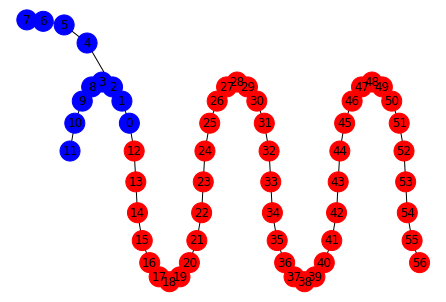

In [5]:
from vermouth.gmx.itp_read import read_itp
from vermouth.forcefield import ForceField
from vermouth.graph_utils import make_residue_graph
ff = ForceField("dummy_name")
with open("PEL.itp") as itp_file:
    lines = itp_file.readlines()
read_itp(lines, ff)
mol = ff.blocks['PEL']
mol.make_edges_from_interaction_type("bonds")
res_mol = make_residue_graph(mol)

plot_graph_nicley(mol, colors={"PEO": "red", 
                               "POPE": "blue"})

Above you see the molecular graph of the PEGylated lipid. In blue is the lipid part with the two tails and in red is the PEG part. Below is the same molecule but now plot as residue graph. 

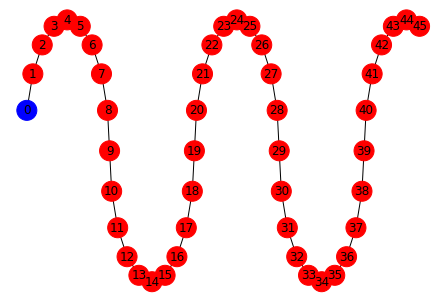

In [6]:
plot_graph_nicley(res_mol, colors={"PEO": "red", 
                               "POPE": "blue"})

Note that we successfully generated the itp not only because we had the parameters of the building blocks but also because the polyply library has the appropiate definitions on how to stitch together the two molecules. This is not always the case. For example, try running the command below, which will try to add Polystyrene to the lipid. You will see that polyply prints a warning telling that the molecule is disconnected. This means no links could be found. It will still print the itp file with the two blocks in it. For adding your own links check out the [PEGylated protein tutorial](https://github.com/marrink-lab/polyply_1.0/wiki/Tutorial:-PEGylated-proteins) or the [writing input files tutorial](https://github.com/marrink-lab/polyply_1.0/wiki/Tutorial:-writing-.ff-input-files). 

In [7]:
!polyply gen_itp -lib martini3 -f additional_files/lipids.itp -name PEL -seq POPE:1 PS:45 -o fail.itp

INFO - step - reading input and library files
INFO - step - reading sequence from command
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 602.57it/s]
WARNING - general - You molecule consists of 2 disjoint parts. Perhaps links were not applied correctly.


Since we know how to generate itp files for linear polymers, we also can generate the itp file for PEG 180 by simply running the above command without the lipid part and adjusting the number of PEG residues.

In [8]:
!polyply gen_params -lib martini3 -seq PEO:180 -name PEO -o PEO.itp

INFO - step - reading input and library files
INFO - step - reading sequence from command
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 101.07it/s]


# 2 - Generation of Dextran input files

Generation of the dextran input files essentially works the same as generation of the PEG/PEGylated lipid input files. However we have to take into account that Dextran is branched and also statistically distributed. Therefore we approach the problem differently. We will generate a number of unique residue graphs with different length and different branching. Subsequently, we will generate input files for each of them such that we have a distribution of dextran molecules for our simulation. 

First, however, we need to collect some facts about dextran to build a good model. Dextran is a polysacharide consisting of only Glucose units. The Glucose units are connected along the main chain by alpha 1->6 linkages. Branches off the main chain are formed by alpha 1->3 linkages. The target molecular weight of the dextran in this example is about 10000 g/mol with a monomer weighing about 162 g/mol. This means in total on average our dextran should have 60 residues. At this molecular weight dextran is only slightly branched with branch length of about 2 glucose units and about 5% of the linkages being branches.[6][7] 

The following python function allows you to generate a graph, that has `n_mon_tot` number of monomers, with branches that have at most a length of `max_mon_side`. In addition it takes a list of numbers, corresponding to the probabilities of adding one more monomer in the side-chain beyond the previous one. If you are familiar with python  have a look and try to understand what this function does. If you are not familiar with python just execute the function and skip to the next cell.

In [9]:
import sys
import random
import json
import numpy as np
import networkx as nx
from networkx.readwrite import json_graph

def write_graph_to_json(graph, filename):
    g_json = json_graph.node_link_data(graph)
    with open(filename, "w") as file_handle:
        json.dump(g_json, file_handle, indent=2)

def random_linear_comb(n_mon_tot, max_mon_side, p_side_chain):
    """
    Generate a graph that consists of a backbone and branches coming off
    the backbone such that the total number of monomers is `n_mon_tot`.
   
    Parameters
    ----------
    n_mon_tot: int
        total number of monomers in the polymer
    max_mon_side:
        the maximum number of monomers per branched off arm
    p_side_chain: list[float]
        probabilities to add at a level corrsponding to the
        position in the list i.e. probability of adding a monomer
        to a side chain beyond the back-bone is list[0], adding a monomer branched
        off 2 level from the back-bone is list[1].
        
    Returns
    --------
    nx.Graph
    """
    G = nx.Graph()
    # add the first edge to get started
    G.add_edge(0, 1, **{"linktype": "a16"})
    # backbone-nodes
    bb_nodes = [0, 1]
    ndx = 1
    prev_node = "BB"
    while ndx < n_mon_tot:
        # then we make the choice back-bone or side-chain
        # but only if we did not add a side-chain before
        # because we build a comb which has only 1 side chain
        # per back-bone otherwise it's a tree
        if prev_node == "BB":
            choice = random.choices(["BB", "SC"], weights=[1-p_side_chain[0], p_side_chain[0]])[0]
        else:
            choice = "BB"

        # if choice is BB we append to the list of BB nodes and continue
        if choice == "BB":
            G.add_edge(bb_nodes[-1], ndx+1, **{"linktype": "a16"})
            ndx += 1
            bb_nodes.append(ndx)
            prev_node = "BB"

        # if choice is SC we start growing a arm
        else:
            # add the first node of the arm
            G.add_edge(bb_nodes[-1], ndx+1, **{"linktype": "a13"})
            ndx += 1
            prev_node = "SC"
            # an arm can have at most max_side_chains monomers beyond first level
            # we add them until we draw a stop
            for sc_idxs in range(1, max_mon_side):
                choice = random.choices(["stop", "add"], weights=[
                                        1-p_side_chain[sc_idxs], p_side_chain[sc_idxs]])[0]
                if choice == "stop":
                    break
                else:
                    G.add_edge(ndx, ndx+1, **{"linktype": "a16"})
                    ndx += 1
                prev_node = "SC"
                # if we exceed the max number of monomers we terminate
                if ndx >= n_mon_tot:
                    return G

        # if we exceed the max number of monomers we terminate
        if ndx >= n_mon_tot:
            return G

Let us generate a graph and see what it does. For illustration purposes let us generate a graph of in total 10 residues, where each residue can have at most 1 arm branching of with a 50% probability. Execute the following cell multiple times and you'll see different graphs with different branching patterns. 

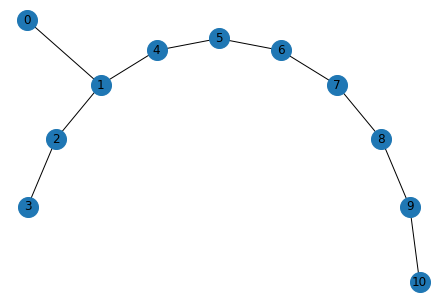

In [10]:
graph = random_linear_comb(10, 2, [0.5, 0.95, 0.95, 0.5])
nx.set_node_attributes(graph, "DEX", "resname")
resids = {node: node+1 for node in graph.nodes}
nx.set_node_attributes(graph, resids, "resid")
plot_graph_nicley(graph, link_labels=True)

Next let us save the graph as a [json file](https://en.wikipedia.org/wiki/JSON). Polyply gen_params at the moment only takes graph input in form of a json file. However, the format is very easy and you can edit it by hand if you need to. The following command will write the graph we just generated to the .json format. 

In [11]:
write_graph_to_json(graph, 'my_first_json_graph.json')
%cat my_first_json_graph.json

{
  "directed": false,
  "multigraph": false,
  "graph": {},
  "nodes": [
    {
      "resname": "DEX",
      "resid": 1,
      "id": 0
    },
    {
      "resname": "DEX",
      "resid": 2,
      "id": 1
    },
    {
      "resname": "DEX",
      "resid": 3,
      "id": 2
    },
    {
      "resname": "DEX",
      "resid": 4,
      "id": 3
    },
    {
      "resname": "DEX",
      "resid": 5,
      "id": 4
    },
    {
      "resname": "DEX",
      "resid": 6,
      "id": 5
    },
    {
      "resname": "DEX",
      "resid": 7,
      "id": 6
    },
    {
      "resname": "DEX",
      "resid": 8,
      "id": 7
    },
    {
      "resname": "DEX",
      "resid": 9,
      "id": 8
    },
    {
      "resname": "DEX",
      "resid": 10,
      "id": 9
    },
    {
      "resname": "DEX",
      "resid": 11,
      "id": 10
    }
  ],
  "links": [
    {
      "linktype": "a16",
      "source": 0,
      "target": 1
    },
    {
      "linktype": "a13",
      "source": 1,
      "target": 2
    

As you can see the file looks somewhat like a written python dictionary. In the file the first interesting element are the 'nodes', which are the residues. Each of them has a resname, resid, and an id that is used internally. If you scroll down you will eventually come to the links section. This section contains information about which nodes are connected as well as a keyword called linktype. The linktype records how the residues are connected. This enables polyply to distinguish between the different carbohydrate connections, if they have different parameters. If you wanted you can also edit all information by hand. Now let us generate an itp-file only for this small dextran oligomer. To do so we simply call gen_params as we did before, however, we specify the `-seqf` flag and provide the name of the json-file we just generated.

In [12]:
!polyply gen_params -lib martini3 -seqf my_first_json_graph.json -name DEX -o oligo_dex.itp

INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 6114.59it/s]


As simple as this we generated an input file for a branched oligomer. Note that of course in this case the building block parameters have been defined in the library. However, in principle you can define those your own as well.

Now that we know how to deal with branching, we are going to deal with the statistical distribution of dextran. Unfortunately the precise molecular weight distribution is unknown. However, we know the average molecular weight and a range for the polydispersity index (~1.5-2). To generate a molecular weight distribution from this we are going to assume that the probability follows that of a linear condensation reaction. In that case we can determine the probability of a given molecular weight from the conversion factor p. The two functions below defines this distribution. 

In [13]:
def probability_by_degree_of_polymerization(p, N):
    """
    Computes the probability for a chain of degree of polymerization
    N based on the extend of reaction p for linear condensation reactions.
    See: Colby and Rubinstein Polymer Physics.
    """
    return N*p**(N-1)*(1-p)**2.

def gen_molecular_weight_distribution(nmols, min_monomers, max_monomers):
    weights = np.arange(min_monomers, max_monomers)
    weight_distribution = probability_by_degree_of_polymerization(0.955, weights)
    random_sample = np.random.choice(weights, p=weight_distribution/np.sum(weight_distribution),
                                     size=int(nmols))
    return random_sample

Of course we don't know the conversion factor either. However, we can adjust it until we get a polydispersity that is within range of what we want. In this case we chose the factor to be 0.955 which yields a polydispersity of about 1.7 that is within the range representative for Dextran. Of course if the molecular weight distribution is known this step can be skipped. The code below will generate 451 Dextran graphs of different molecular weight according to the distribution charactersitics we just defined and plot the samples as well as distribution and compute some metrics. 

The number average molecular weight is  9541.311485587585  g/mol
The weight average molecular weight is  15365.714640813718  g/mol
The polydispersity index is  1.610440521098599


Text(0.5, 0, 'number average molecular weight')

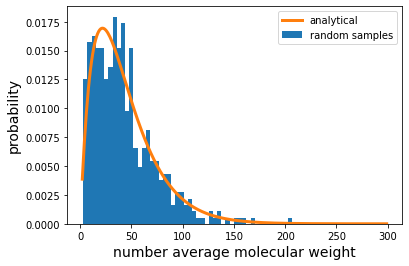

In [14]:
# input variables for dextran
max_molecular_weight = 300
min_molecular_weight = 2
total_number_dextrans = 451

# let us generate the samples by drawing from the know distribution
molecular_weight_samples = gen_molecular_weight_distribution(total_number_dextrans, 
                                                             min_molecular_weight, 
                                                             max_molecular_weight)

# now let us calculate some characteristics of that distribution
probs, weights = molecular_weight_distr(molecular_weight_samples)
print("The number average molecular weight is ", number_average_molecular_weight(probs, weights), " g/mol")
print("The weight average molecular weight is ", weight_average_molecular_weight(probs, weights), " g/mol")
print("The polydispersity index is ", polydispersity_index(probs, weights))

# finally we'll plot everything
_ = plt.hist(molecular_weight_samples, bins=50, density=True, label='random samples')
plt.plot(np.arange(2, 300), probability_by_degree_of_polymerization(0.955, np.arange(2, 300)),
         lw=3, label='analytical')
plt.legend()
plt.ylabel('probability', fontsize=14)
plt.xlabel('number average molecular weight', fontsize=14)

Next we simply save a json graph file according to the protocol used before for each of the molecular weight samples we just generated. Note that in this instance we assume each branch beyond the backbone has a 0.95 percent probability of existing until the third residue, which only has 0.5 percent chance. That should take care that the branches are about 2-3 Glucose units, which is expected at this molecular weight. 

In [15]:
!if [ -d "json_graphs" ]; then rm -r "json_graphs"; fi
!mkdir json_graphs
json_files = []
for idx, n_mon in enumerate(molecular_weight_samples):
    graph = random_linear_comb(n_mon, 2, [0.05, 0.95, 0.95, 0.5])
    nx.set_node_attributes(graph, "DEX", "resname")

    resids = {node: node+1 for node in graph.nodes}
    nx.set_node_attributes(graph, resids, "resid")

    filename = "json_graphs/DEX_" + str(n_mon) + "_" + str(idx) + ".json"
    json_files.append(filename)
    write_graph_to_json(graph, filename)

Finally we loop over each of the Dextran graph files and generate an itp file for each of them. Because looping over shell commands can sometimes be tricky from within jupyter notebooks, we have written the loop in bash and stored it in the script gen_dex_itps.sh. It also collects all single itps into one file so we later just have to include a single file with all Dextran molecule definitions. Note that this step dependin on your Python version and computer takes anywhere from 5-15min.

In [16]:
!if [ -d "dextrans.itp" ]; then rm -f "dextrans.itp"; fi
!if [ -d "dextran_itps" ]; then rm -r "dextran_itps"; fi
!mkdir dextran_itps
!bash additional_files/gen_dex_itps.sh

json_graphs/DEX_10_100.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 396.79it/s]
json_graphs/DEX_103_127.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 29.56it/s]
json_graphs/DEX_103_378.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 22.63it/s]
json_graphs/DEX_10_367.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequen

json_graphs/DEX_12_52.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 206.71it/s]
json_graphs/DEX_126_210.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 23.79it/s]
json_graphs/DEX_126_346.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 23.20it/s]
json_graphs/DEX_12_70.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence

json_graphs/DEX_15_42.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 140.37it/s]
json_graphs/DEX_155_290.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 20.36it/s]
json_graphs/DEX_162_250.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 16.59it/s]
json_graphs/DEX_16_262.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequenc

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 38.78it/s]
json_graphs/DEX_23_306.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 70.56it/s]
json_graphs/DEX_23_61.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 72.77it/s]
json_graphs/DEX_23_74.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 65.30it/s]
json_graphs/DEX_24_182.json
INFO - step - reading input and librar

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 127.51it/s]
json_graphs/DEX_28_320.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 142.97it/s]
json_graphs/DEX_28_353.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 160.43it/s]
json_graphs/DEX_28_360.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 158.09it/s]
json_graphs/DEX_29_19.json
INFO - step - reading input and libra

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 29.21it/s]
json_graphs/DEX_32_429.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 126.41it/s]
json_graphs/DEX_3_245.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 983.96it/s]
json_graphs/DEX_32_6.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 159.03it/s]
json_graphs/DEX_32_88.json
INFO - step - reading input and library 

json_graphs/DEX_36_109.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 85.78it/s]
json_graphs/DEX_36_178.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 136.42it/s]
json_graphs/DEX_36_24.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 124.86it/s]
json_graphs/DEX_36_260.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence 

json_graphs/DEX_40_170.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 103.73it/s]
json_graphs/DEX_40_194.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 119.57it/s]
json_graphs/DEX_40_419.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 112.21it/s]
json_graphs/DEX_40_41.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence 

json_graphs/DEX_43_325.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 86.02it/s]
json_graphs/DEX_43_47.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 101.09it/s]
json_graphs/DEX_43_63.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 88.75it/s]
json_graphs/DEX_4_388.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 97.56it/s]
json_graphs/DEX_53_450.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 68.27it/s]
json_graphs/DEX_54_251.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 83.35it/s]
json_graphs/DEX_54_321.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 67.69it/s]
json_graphs/DEX_54_354.json
INFO - step - reading input and libr

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 72.31it/s]
json_graphs/DEX_63_246.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 66.21it/s]
json_graphs/DEX_6_374.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 659.59it/s]
json_graphs/DEX_6_381.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 636.50it/s]
json_graphs/DEX_64_106.json
INFO - step - reading input and librar

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 54.60it/s]
json_graphs/DEX_71_349.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 59.30it/s]
json_graphs/DEX_72_140.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 56.12it/s]
json_graphs/DEX_72_18.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 57.33it/s]
json_graphs/DEX_72_329.json
INFO - step - reading input and libra

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 46.71it/s]
json_graphs/DEX_8_123.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 504.06it/s]
json_graphs/DEX_81_333.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 42.60it/s]
json_graphs/DEX_8_160.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 478.17it/s]
json_graphs/DEX_81_94.json
INFO - step - reading input and library

json_graphs/DEX_9_212.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 463.44it/s]
json_graphs/DEX_92_287.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 35.85it/s]
json_graphs/DEX_9_278.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to molecule
INFO - step - applying links between residues
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 423.67it/s]
json_graphs/DEX_9_319.json
INFO - step - reading input and library files
INFO - step - reading sequence from file
INFO - step - mapping sequence to

# 3 - Generation of inital coordinates

Now we have everything in place to build the system. To build a system with polyply we simply need the topology file for the entire system. In addition polyply can read starting coordinates of parts of the system that have been generated before as well as restrictions on how and where to put the polymers. The only input, however, that is required for the polyply coordinate generator is the topology file and either the box-size or the total density of the system. So let us first write the topology file.

We include the martini3 bead definitions, the parameters for ions, lipids, as well as the PEO, dextran and PEGylated lipid itp file into our topology file. Note that we have already generated a vesicle with TS2CG and obtained the proper composition from the program. To see how to generate vesicles checkout the TS2CG tutorial. 

In [17]:
top_file="""#include "additional_files/martini_v3.0.0.itp"
#include "additional_files/martini_v3.0.0_ions_v1.itp"
#include "additional_files/lipids.itp"
#include "dextrans.itp"
#include "PEO.itp"
#include "PEL.itp"
[ system ]
test
[ molecules ]
DOPC 4470
DPPC 4470
CHOL 3944
PEL  262
DOPC 3287
DPPC 3287
CHOL 2900
PEL  193
PEO  620
"""

with open("system.top", "w") as _file:
    _file.write(top_file)

    for dex_idx in range(0, total_number_dextrans):
        _file.write("dex"+str(dex_idx)+" 1 \n")
        
    _file.write("NA 262\n")
    _file.write("NA 193\n")

Since we want the polymers in our system to be placed inside the vesicle and within the vesicle to be already phase separated, we have to provide polyply with these restrictions on the build. This can be done via the buildfile, which allows to define geometric restrictions for groups of molecules. The geometric restrictions at the moment are limited to defining that a molecule must be placed inside or outside a sphere, cylinder, rectangle, or any combination of those. The syntax of the file is as follows:

1. define to which molecule the restriction applies, by writing the [molecule] directive as shown below with the molecule name and the first and last index of the molecules to consider. The molecule index counts over all molecules starting at 0. 

```
[ molecule ]
; molname
<name_of_molecule> <first_mol_idx> <last_mol_idx>
```

2. Add any of the sphere, cylinder, or rectangle directive. Each directive starts with the resname that this restriction applies to as well as a range of resids to consider. Note resids start counting at 0! After writing the resid there must be one of the keyworkds inside or outside. This defines if we want to the molecule to be included in the region of space or excluded from it. Finally, we have to define the sphere, cylinder or rectangle. For all objects you first write the center of the object, and then 
    - in case of a spehre the radius,
    - in case of the cylinder the z-dimension as well as the distance of the z-axis to the wall of the cylinder
    - in case of a rectangle the distance from the center to the 3 faces of the recangle.

For example the proto syntax for defining a sphere would be:
```
[ sphere ]
<resname> <first_resid> <last_resid> <inside/out> <x-center> <y-center> <z-center> <radius>
```

Now that we know of the buildfile syntax we need to think carefully about what the final system should look like. First, we note that there are PEGylated lipids in the inner and outer-monolayer. We don't want the PEG-part of the outer PEGylated lipids to grow into the vesicle. Even though this is hindered by including the lipid bilayer in the super-CG random-walk, it can happen. Thus it is safer to tell the program that the outer PEGylated lipid PEG-part has to stay outside the vesicle. For that we need to define the radius of the vesicle for the inner and outer bilayer surface. To do so we compute the center of geometry of the head-groups, which will give us the approximate center of the sphere. Then we compute the distance of each head-group from the center and make a histogram, which will give us an approximate inner and outer radius. Note that it is approximate because the vesicle is not perfectly spherical. 

/home/fabian/polyply_presentation/venv/lib/python3.6/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/fabian/polyply_presentation/venv/lib/python3.6/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/fabian/polyply_presentation/venv/lib/python3.6/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: R
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


The center of the vesicale is located at:  [318.3421  319.4145  318.87793]
The distance of the outer monolayer surace to the center is:  266.20395
The distance of the inner monolayer surface to the center is:  229.25452


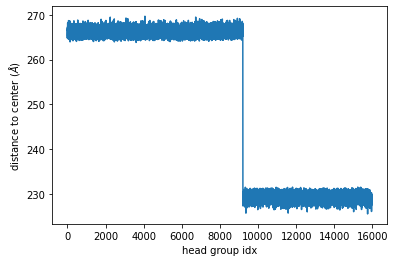

In [18]:
import MDAnalysis as mda

u = mda.Universe("additional_files/vesicle.gro")
head_groups = u.select_atoms("name PO4")
center = np.average(head_groups.positions, axis=0)
print("The center of the vesicale is located at: ",  center)
distances = np.apply_along_axis(np.linalg.norm, 1, head_groups.positions - center)
plt.plot(distances)
plt.xlabel("head group idx")
plt.ylabel("distance to center ($\AA$)")
radius_outer = np.average(distances[: 8000])
radius_inner = np.average(distances[10000:])
print("The distance of the outer monolayer surace to the center is: ", radius_outer)
print("The distance of the inner monolayer surface to the center is: ", radius_inner)

Now we can already write the entry for the PEGylated lipid PEG-part into the build file, which is done by the code below. Checkout the doc-string to learn more about the format. Note that resids also start at 0! and that we exclude the first PEG residue, because that will lie approximately within the head group region.

In [19]:
def sphere_template(molname, 
                    mol_idx_start, 
                    mol_idx_stop, 
                    resname, 
                    start_resid, 
                    stop_resid, 
                    inside_out, 
                    center, 
                    radius):
    """
    Return properly formatted string for single molecule and single residue following the polypy build format. 
    
    Parameters:
    -----------
    molname: str
        name of the molecule
    mol_idx_start: int
        index of the first molecule to consider; note mol indices start at 0 and run over all molecules
    mol_idx_stop: int
        index of the first molecule not to consider
    resname: str
        resname of residues to consider
    start_resid: int
        first residue to consider
    stop_resid: int
        first residue not to consider
    inside_out: str
        one of "in" or "out"
    center: np.array(3)
        center of the sphere
    radius: float
        radius of the sphere
    """
    template="""
    [ molecule ]
    ; molname
    {:s} {:d} {:d}
    [ sphere ]
    ; resname start stop  inside-out  x  y  z    r
    {:s} {:d} {:d} {:s} {:3.2F} {:3.2F} {:3.2F} {:3.2F}
     """
    new_entry  = template.format(molname, 
                                 mol_idx_start, 
                                 mol_idx_stop, 
                                 resname, 
                                 start_resid, 
                                 stop_resid, 
                                 inside_out, 
                                 center[0],
                                 center[1],
                                 center[2],
                                 radius)
    return new_entry
    
with open("build_file.bld", "w") as _file:
    _file.write(sphere_template("PEL", 12880, 13150, "PEO", 2, 45, "out", center/10., radius_outer/10.))
    _file.write(sphere_template("PEL", 22610, 22820, "PEO", 2, 45, "in", center/10., radius_inner/10.))

In [20]:
!cat build_file.bld


    [ molecule ]
    ; molname
    PEL 12880 13150
    [ sphere ]
    ; resname start stop  inside-out  x  y  z    r
    PEO 2 45 out 31.83 31.94 31.89 26.62
     
    [ molecule ]
    ; molname
    PEL 22610 22820
    [ sphere ]
    ; resname start stop  inside-out  x  y  z    r
    PEO 2 45 in 31.83 31.94 31.89 22.93
     

Next we consider that the PEGylated lipids are charged so they have to be neutralized. From the topology file we know that there are 262 PEGylated lipids in the outer and 192 in the inner leaflet. So we can for example, put 262 sodium ions outside and 192 inside. Again we use the same information as for the PEGylated lipids. 

In [21]:
with open("build_file.bld", "a") as _file:
    _file.write(sphere_template("NA", 23933, 24196, "NA", 0, 1, "out", center/10., radius_outer/10.))
    _file.write(sphere_template("NA", 24196, 24389, "NA", 0, 1, "in", center/10., radius_inner/10.))

Now we come to the interesting part, that is generating the PEG Dextran phase separated system. First we note that we will have to add a directive similar to the ones before, because we want the two polymers to be inside the vesicle. Then on top of that we will apply the rectangle directive to tell polyply that one polymer should be in one part of the vesicle and the other one in the remaining space. However, there are two more things to consider: 1) the Dextran phase is known to be denser (i.e. smaller); 2) there is some  mixing at the interface. Unfortunately there are no details of exactly how much denser the PEG, Dextran phase is. By simulation of a simple PEG/Dextran mixture in Martini, we found that the number density of residues is about 1.8 times higher for the Dextran phase. The interface is approximately 3nm in width. This means the volume of the PEO phase should be 1.8 times higher than that of Dextran. 

Taking this into account we can compute how much space Dextran and PEG take up in the vesicle. As shown below we find that the Dextran phase has to be a spherical cap with 18.5nm height given the radius of our vesicle, plus 3.0 nm for the interface.

In [22]:
a_dextran = 185
(volume_sphere(radius_inner)-(volume_sphereical_cap(a_dextran-3., radius_inner)))/(volume_sphereical_cap(a_dextran+3, radius_inner))

1.7932208581686107

The following plot shows how the geometrical restrictions play together in this case.

Center Dextran Phase:  196.58758544921875
Center PEO Phase:  395.84210205078125
92.5
136.7545166015625


Text(0, 0.5, 'y-coordinates ($\\AA$)')

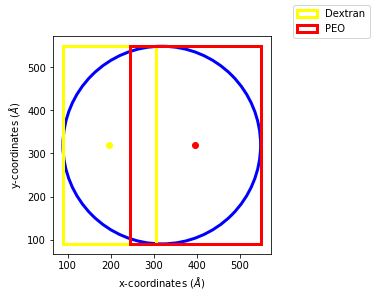

In [23]:
fig, ax = plt.subplots()
circle = plt.Circle(center, radius=radius_inner, edgecolor='blue', fill=False, lw=3)

rectangle_DEX = plt.Rectangle(center - radius_inner, width=a_dextran+30, height=radius_inner*2, 
                              edgecolor='yellow', fill=False, lw=3, label='Dextran')

a_PEO = (2*radius_inner - a_dextran)/2. 
rectangle_PEO = plt.Rectangle([center[0] - radius_inner + a_dextran - 30, 
                               center[1] - radius_inner], 
                               width=a_PEO*2+30,
                               height=radius_inner*2, edgecolor='red', fill=False,lw=3,
                               label='PEO')

center_dex = center[0] - radius_inner + (a_dextran+30)/2.
center_peo = center[0] + radius_inner - (radius_inner+(radius_inner-a_dextran)+30)/2.
print("Center Dextran Phase: ", center_dex)
print("Center PEO Phase: ", center_peo)
print(a_dextran/2.)
print(a_PEO)
ax.plot(center[0] - radius_inner + (a_dextran+30)/2., center[1],  marker='o', c='yellow')
ax.plot(center[0] + radius_inner - (radius_inner+(radius_inner-a_dextran)+30)/2., center[1],  marker='o', c='red')

ax.add_patch(circle)
ax.add_patch(rectangle_DEX)
ax.add_patch(rectangle_PEO)
ax.set_box_aspect(1)
legend = fig.legend()
plt.xlabel("x-coordinates ($\AA$)")
plt.ylabel("y-coordinates ($\AA$)")

The above plot shows the 2D representation of the vesicle system. Blue marks the position of the inner monolayer headgroups and thus the inside of the vesicle. The area formed by the blue circle and the yellow rectangle forms the region where dextran is allowed and likeise the red rectangle marks the space where PEO is allowed. The polyply build file specfies rectangles as their center (indicated by the points) and the distance to the three faces of the ractangle.

In [24]:
template_PEO = """
[ molecule ]
; molname
PEO 22800 23500
[ sphere ]
; resname start stop  inside-out  x  y  z    r
 PEO     1    200    in        {:3.2F} {:3.2F} {:3.2F} {:3.2F}
[ rectangle ]
; resname start stop  inside-out  x  y  z            a   b    c
 PEO     1    200    in         {:3.2F} {:3.2F} {:3.2F} {:3.2F} {:3.2F} {:3.2F} 
"""

with open("build_file.bld", "a") as _file:
    _file.write(template_PEO.format(center[0]/10, 
                                    center[1]/10., 
                                    center[2]/10.,
                                    radius_inner/10.,
                                    center_peo/10.,
                                    center[1]/10,
                                    center[2]/10,
                                    (a_PEO+30)/10.,
                                    radius_inner/10,
                                    radius_inner/10))
        
template = """[ sphere ]
; resname start stop  inside-out  x       y       z       r
 DEX     1    600    in        {:3.2F} {:3.2F} {:3.2F} {:3.2F}
[ rectangle ]
; resname start stop  inside-out  x       y       z       a      b        c
 DEX     1    600    in       {:3.2F} {:3.2F} {:3.2F} {:3.2F} {:3.2F} {:3.2F} 
"""
tot_num_mols = 23433
with open("build_file.bld", "a") as _file:
    for dex_idx in range(0, total_number_dextrans):
        _file.write("[ molecule ]\n")
        _file.write("dex{} {} {}\n".format(dex_idx, tot_num_mols +dex_idx, tot_num_mols+dex_idx+1))
        _file.write(template.format(center[0]/10, 
                                    center[1]/10., 
                                    center[2]/10.,
                                    radius_inner/10.,
                                    center_dex/10.,
                                    center[1]/10,
                                    center[2]/10,
                                    (a_dextran/2.+30)/10.,
                                    radius_inner/10,
                                    radius_inner/10))

Now everything is in place to generate the inital structure by running polyply gen_coords as follows. Note that this might take about 15min with numba installed. So start the commad and then read the explanation of the individual parts below. Without the numba library it probably takes anywhere from 15-60min. 

In [25]:
!polyply gen_coords -p system.top -c additional_files/vesicle.gro -res PEO DEX -o start.gro -name test -box 65 65 65 -b build_file.bld -split POPE:HEAD-NH3:TAIL-PO4,GL1,GL2,C1A,D2A,C3A,C4A,C1B,C2B,C3B,C4B

INFO - step - reading topology
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 769.31it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 415.15it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 300.93it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 228.77it/s]


100%|██████████████████████████████████████| 193/193 [00:00<00:00, 23674.46it/s]
INFO - step - processing topology
INFO - step - splitting residues
INFO - step - loading coordinates
INFO - step - reading build file
INFO - step - generating templates
 18%|██████▉                               | 4471/24339 [00:00<50:13,  6.59it/s]WARNING - general - Failed to optimize structure for block CHOL.
WARNING - general - Proceeding with unoptimized coordinates.
WARNING - general - Usually this is OK, but check your final structure.
100%|███████████████████████████████████| 24339/24339 [00:07<00:00, 3300.53it/s]
INFO - step - annotating ligands
INFO - step - generating system coordinates
100%|█████████████████████████████████████| 24339/24339 [15:12<00:00, 26.68it/s]
INFO - step - backmapping to target resolution
100%|████████████████████████████████████| 24339/24339 [01:50<00:00, 220.51it/s]
INFO - step - writing output


When generating coordinates with polyply we always have to specify the `-p` flag and provide a (GROMACS) topology file. Furthermore, we either have to define the total system density setting `-dens` or the system box using `-box` specifying the x, y, z component of the box. At the moment polyply only supports rectangular boxes. Furthermore, the name of the output file is given by `-o`. The last mandatory thing to do is to provide the name of the system with `-name`. 

In our case we have some more information to provide. Using the `-b` flag we specify the name of the build file that contains all geometric restrictions specific to our system. Furthermore, with the `-c` option we provide the coordinates of the vesicle. In general you can provide coordinates for any part of the system that were already obtained from elsewhere. However, the n coordinates provided are assinged to the first n-beads in the system unless you specify using the `-res` flag residues that have to be built. In that case coordinates are assinged to the first n-beads excluding all residues listed there. In our case we have the PEGylated lipids in the middel of the coordinate files, however, without the PEO tail. By specifying PEO coordinates are still correctly assigened skipping those of the PEG tail, which needs to be grown. 

In addition to the options mentioned in the previous paragraph, we also split the residue POPC into two separate residues describing the lipid head-group and the lipid tail region. Run polyply gen_coords -h to get more information on the splitting syntax. Splitting the residues is needed, because polyply generates a super-coarse grained 1 bead per residue model. However, Martini lipids in general are one residue. This can generate problems, because PEO is attached to the head group and we want to start "growing" the chain from there. Given that the lipid, however, is one residue in the coordinate generation the program would instead do one large step from the enter of the lipid, which typically yields less good configurations. Note that the split option is just a convience flag. We could also simply have given the lipid different residue names for the tial and head group. 

Now that the system is completed let us view it in vmd. 

In [26]:
!vmd start.gro

Info) VMD for LINUXAMD64, version 1.9.3 (October 28, 2018)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 4 CPUs detected.
Info) Free system memory: 10GB (67%)
Warning) Detected X11 'Composite' extension: if incorrect display occurs
Warning) try disabling this X server option.  Most OpenGL drivers
Warning) disable stereoscopic display when 'Composite' is enabled.
Info) OpenGL renderer: Mesa DRI Intel(R) HD Graphics 620 (KBL GT2)
Info)   Features: STENCIL MSAA(4) MDE CVA MTX NPOT PP PS GLSL(OVFS) 
Info)   Full GLSL rendering mode is available.
Info)   Textures: 2-D (16384x16384), 3-D (512x512x512), Mu

Finally you can add water to the system with your most favorite tool for solvation. Because there are so many water molecules in the system adding them with polyply will take a long time, whereas more optimized solvation strategies and programs exists. For the sake of this tutorial we will be using SOL from TS2CG which placed water molecules from a reference box. 

In [27]:
! additional_files/SOL -in start.gro -o solvated.gro -tem additional_files/W.gro

----> We could generate UCELLS 
Warrning: particle is out of the box 
Warrning: particle is out of the box 
----> We could make the cells  


We also need to add the number of water molecules to the topology file for later use. 

In [28]:
!cat info.txt >> system.top

Let's visulaize it again to see that the water was actually added. 

In [29]:
!vmd solvated.gro

Info) VMD for LINUXAMD64, version 1.9.3 (October 28, 2018)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 4 CPUs detected.
Info) Free system memory: 10GB (67%)
Warning) Detected X11 'Composite' extension: if incorrect display occurs
Warning) try disabling this X server option.  Most OpenGL drivers
Warning) disable stereoscopic display when 'Composite' is enabled.
Info) OpenGL renderer: Mesa DRI Intel(R) HD Graphics 620 (KBL GT2)
Info)   Features: STENCIL MSAA(4) MDE CVA MTX NPOT PP PS GLSL(OVFS) 
Info)   Full GLSL rendering mode is available.
Info)   Textures: 2-D (16384x16384), 3-D (512x512x512), Mu

Finally we can run an energy minization. Note that without a decently large GPU even on a Desktop this run will take some time. But you can start it to see that it actually works. 

# References
[1] Sing, C.E., 2017. Development of the modern theory of polymeric complex coacervation. Advances in colloid and interface science, 239, pp.2-16.

[2]Long, R., Hui, C.Y., Gong, J.P. and Bouchbinder, E., 2021. The fracture of highly deformable soft materials: A tale of two length scales. Annual Review of Condensed Matter Physics, 12, pp.71-94.

[3] Zwicker, D., Seyboldt, R., Weber, C.A., Hyman, A.A. and Jülicher, F., 2017. Growth and division of active droplets provides a model for protocells. Nature Physics, 13(4), pp.408-413.

[4] Brangwynne, C.P., Tompa, P. and Pappu, R.V., 2015. Polymer physics of intracellular phase transitions. Nature Physics, 11(11), pp.899-904.

[5] Andes-Koback, M. and Keating, C.D., 2011. Complete budding and asymmetric division of primitive model cells to produce daughter vesicles with different interior and membrane compositions. Journal of the American Chemical Society, 133(24), pp.9545-9555.

[6] Gekko, K. and Noguchi, H., 1971. Physicochemical studies of oligodextran. I. Molecular weight dependence of intrinsic viscosity, partial specific compressibility and hydrated water. Biopolymers: Original Research on Biomolecules, 10(9), pp.1513-1524.

[7] Gasciolli, V., Choplin, L., Paul, F. and Monsan, P., 1991. Viscous properties and molecular characterization of enzymatically size-controlled oligodextrans in aqueous solutions. Journal of biotechnology, 19(2-3), pp.193-202.